In [110]:
# All imported libraries are listed herefor readbility

import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
from zlib import crc32


# Data pipeline, scaling, normalizing, etc
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Transforming & Manipulating data
from sklearn.compose import ColumnTransformer


# The Linear Regression model
from sklearn.linear_model import LinearRegression



In [111]:
# Define parameters for data retrieval
INSTRUMENT_ID = '1'
START = "2021-01-20T00:00"
END = "2021-01-21T00:00"


In [112]:
def load_olo_data(instrument_id, start, end):
    url = f'http://tzvolcano.chordsrt.com/api/v1/data/{instrument_id}.csv?start={start}&end={end}'
    print(url)

    
    return pd.read_csv(url,
#                     index_col='Time', 
                    parse_dates=['Time'],
                    header=18
                    )


# original_data.info()
# original_data.describe()
# original_data.head()
    


In [113]:
original_data = load_olo_data(INSTRUMENT_ID, START, END)

http://tzvolcano.chordsrt.com/api/v1/data/1.csv?start=2021-01-20T00:00&end=2021-01-21T00:00


In [114]:
# Calculate the seconds_since_epoch variable
original_data["seconds_since_epoch"] = original_data['Time'].astype(np.int64)

# Show all the keys (variable names) in the loaded data set
original_data.keys()

Index(['Time', 'Latitude', 'Longitude', 'Height', 'seconds_since_epoch'], dtype='object')

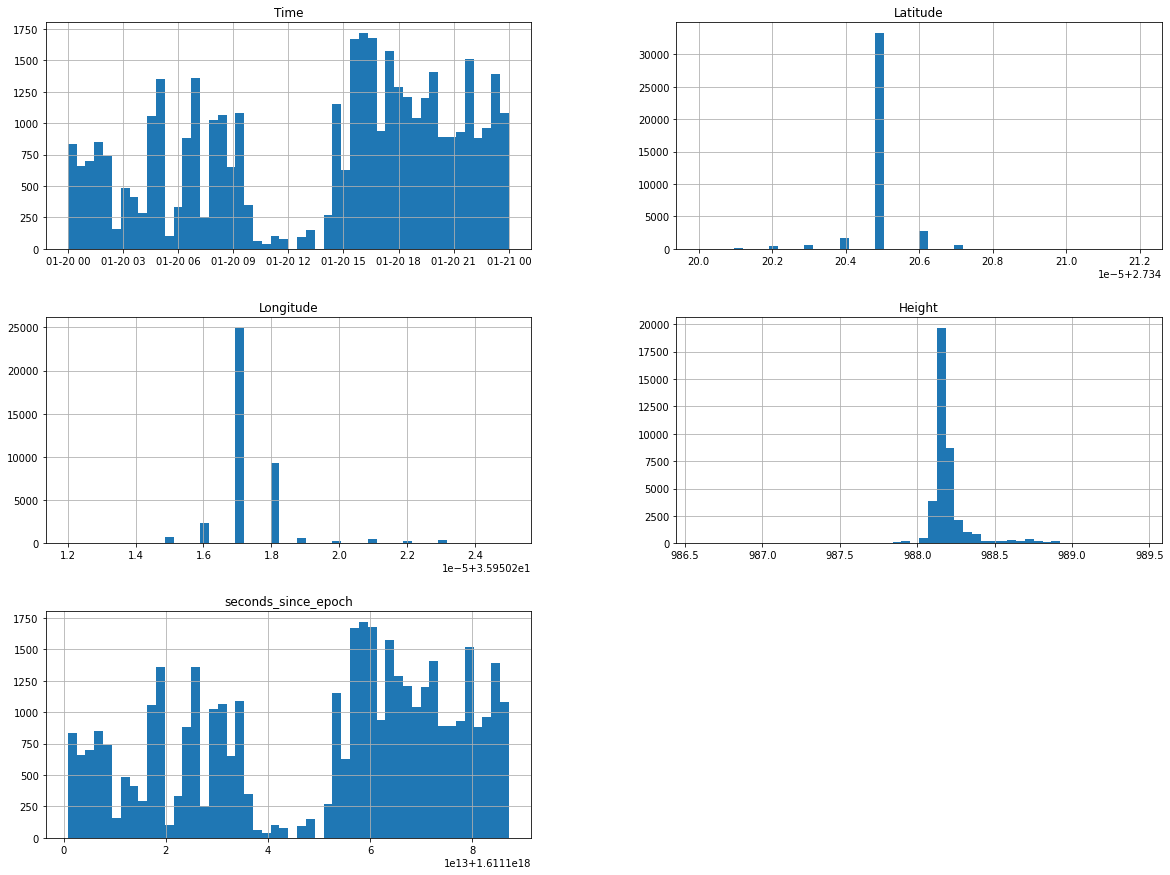

In [115]:
# Plot histograms for the data
original_data.hist(bins=50, figsize=(20,15))
plt.show()

<AxesSubplot:xlabel='Height', ylabel='Latitude'>

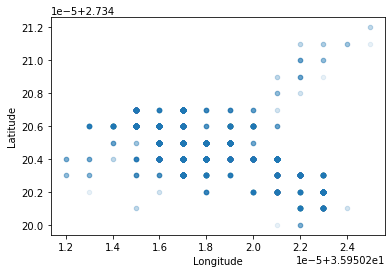

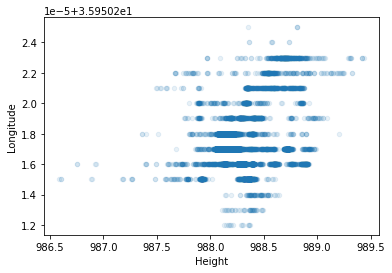

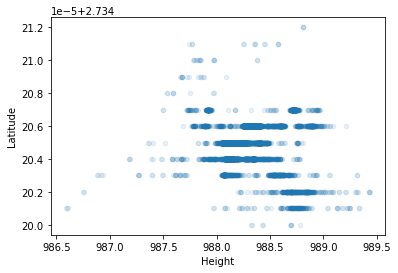

In [116]:
# Create scatter plots for Longitude & Latitude
# Scatter plots are useful to identify patterns between the variables 
# and to see which ones will be useful for machine learning)
original_data.plot(kind="scatter", x="Longitude", y="Latitude", alpha=0.1)
original_data.plot(kind="scatter", x="Height", y="Longitude", alpha=0.1)
original_data.plot(kind="scatter", x="Height", y="Latitude", alpha=0.1)

<AxesSubplot:xlabel='seconds_since_epoch'>

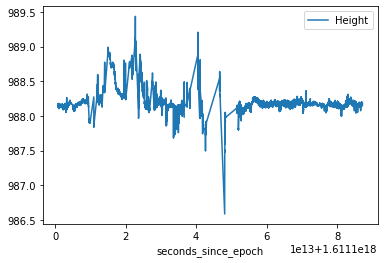

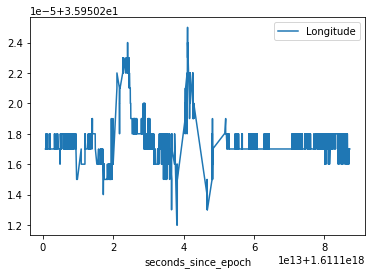

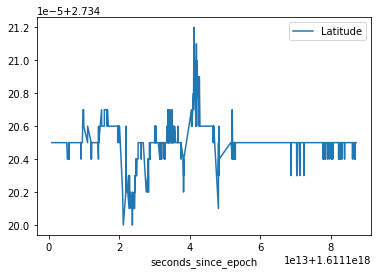

In [117]:

original_data.plot(x="seconds_since_epoch", y="Height")
original_data.plot(x="seconds_since_epoch", y="Longitude")
original_data.plot(x="seconds_since_epoch", y="Latitude")

In [118]:
# Show correclations between the variables
original_data.corr()

,Latitude,Longitude,Height,seconds_since_epoch
Latitude,1.000000,-0.595932,-0.128861,-0.019550
Longitude,-0.595932,1.000000,0.321485,-0.019791
Height,-0.128861,0.321485,1.000000,-0.292838
seconds_since_epoch,-0.019550,-0.019791,-0.292838,1.000000


In [119]:
# Show an overview of info about the data
original_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39491 entries, 0 to 39490
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   Time                 39491 non-null  datetime64[ns, UTC]
 1   Latitude             39491 non-null  float64            
 2   Longitude            39491 non-null  float64            
 3   Height               39491 non-null  float64            
 4   seconds_since_epoch  39491 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(3), int64(1)
memory usage: 1.5 MB


In [120]:
original_data.keys()

Index(['Time', 'Latitude', 'Longitude', 'Height', 'seconds_since_epoch'], dtype='object')

In [121]:
def split_train_test(data, test_ratio):
    #     Seed ramdom generator so the same indices are retrieved every time
    np.random.seed(42)
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

# Split the original data in to two sets: one used for training and one used for testing the generated model
#  .2  = 20% of the total data set will be used as test data
train_data, test_data = split_train_test(original_data, 0.2)

# Show how many entries are in the total, training and test sets (jsut for confirmation)
print(len(original_data))
print(len(train_data))
print(len(test_data))

39491
31593
7898


In [122]:
train_data.keys()

Index(['Time', 'Latitude', 'Longitude', 'Height', 'seconds_since_epoch'], dtype='object')

In [123]:
# Remove the "Time" variable from the data set, as it is not useful for the model
numerical_data = original_data.drop(["Time"], axis=1)

# Print out the remaing variable names, just to see we did remove "Time"
numerical_data.keys()

Index(['Latitude', 'Longitude', 'Height', 'seconds_since_epoch'], dtype='object')

In [124]:
# Define a pipline to clean numerical data
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])

# Test that the pipeline works
original_transformed = num_pipeline.fit_transform(numerical_data)

In [125]:
# Definte the pipleine for ALL the data 
# (right now we only have numerical data, but this is not always the case)

num_attributes = list(numerical_data)

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attributes)
])

# Prepare the full set of training data
training_prepared = full_pipeline.fit_transform(numerical_data)

In [126]:
# Build and train the Linear Regression Model
lin_reg = LinearRegression()
lin_reg.fit(training_prepared,training_prepared)

LinearRegression()

In [127]:
# Run a few predictions
some_data = numerical_data.iloc[:5]
# some_labels = numerical_data.iloc[:5].drop('Latitude', axis=1).drop('Longitude', axis=1).drop('Height', axis=1)
some_labels = numerical_data.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions", lin_reg.predict(some_data_prepared))
print("Labels", list(some_labels))

Predictions [[ 0.0311088  -0.29646267 -0.26407049 -1.92095115]
 [ 0.0311088  -0.29646267 -0.31372687 -1.92091246]
 [ 0.0311088  -0.29646267 -0.33500818 -1.92087377]
 [ 0.0311088  -0.29646267 -0.23569541 -1.92083508]
 [ 0.0311088  -0.29646267 -0.24278918 -1.92079639]]
Labels ['Latitude', 'Longitude', 'Height', 'seconds_since_epoch']
